### Decision Tree (Processed & Parameters)

In [ ]:
# Remove Crm Cd Desc to avoid leakage
df_model_2 = df_new_1.copy()

# Prepare training data
X = df_model_2.drop(columns=["Crime_Class"])
y, _ = pd.factorize(df_model_2["Crime_Class"])

# Convert datetime columns to int64 timestamps
for col in X.select_dtypes(include=["datetime", "datetimetz"]).columns:
    X[col] = X[col].view('int64')

# Convert list columns to strings so they can be factorized
for col in X.columns:
    if X[col].apply(lambda x: isinstance(x, list)).any():
        X[col] = X[col].astype(str)

# Factorize object columns
X = X.apply(lambda col: pd.factorize(col)[0] if col.dtype == "object" else col)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ============================================================
# 🔥 FAST HYPERPARAMETER TUNING — SUCCESSIVE HALVING
# ============================================================

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

halving_search = HalvingGridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    factor=3,      # aggressively eliminates bad configs
    resource="n_samples",
    max_resources="auto",
    n_jobs=-1,
    verbose=1
)

halving_search.fit(X_train, y_train)

print("Best Parameters:", halving_search.best_params_)

# Best model
dt_model_4 = halving_search.best_estimator_

# ============================================================
# Prediction and Evaluation
# ============================================================

# Predict
y_pred = dt_model_4.predict(X_test)
y_pred_train = dt_model_4.predict(X_train)

# Eval reports
report_test = pd.DataFrame.from_dict(
    classification_report(y_test, y_pred, output_dict=True)
).transpose()

report_train = pd.DataFrame.from_dict(
    classification_report(y_train, y_pred_train, output_dict=True)
).transpose()

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Set Accuracy:", train_accuracy)
print("Testing Set Accuracy:", test_accuracy)
print("------------------------------------------------------------------------------------")
print("Training Set Report")
print("------------------------------------------------------------------------------------")
print(report_train)
print("------------------------------------------------------------------------------------")
print("Testing Set Report")
print("------------------------------------------------------------------------------------")
print(report_test)
print("------------------------------------------------------------------------------------")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 26055
max_resources_: 703493
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 26055
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 78165
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 234495
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 703485
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


c:\Users\wongj_gwtzhu8\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wongj_gwtzhu8\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wongj_gwtzhu8\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

Training Set Accuracy: 0.8912043190195211
Testing Set Accuracy: 0.8901253076305647
------------------------------------------------------------------------------------
Training Set Report
------------------------------------------------------------------------------------
              precision    recall  f1-score        support
0              0.929658  0.927457  0.928556  356035.000000
1              0.916610  0.959116  0.937382  163391.000000
2              0.679806  0.581331  0.626724   44202.000000
3              0.821368  0.949977  0.881004   86340.000000
4              0.671077  0.761015  0.713222   13595.000000
5              0.936715  0.450374  0.608284    8282.000000
6              0.977356  0.877030  0.924479   15207.000000
7              0.735199  0.309022  0.435143   13944.000000
8              0.000000  0.000000  0.000000     540.000000
9              0.778934  0.306081  0.439472    1957.000000
accuracy       0.891204  0.891204  0.891204       0.891204
macro avg      0.74

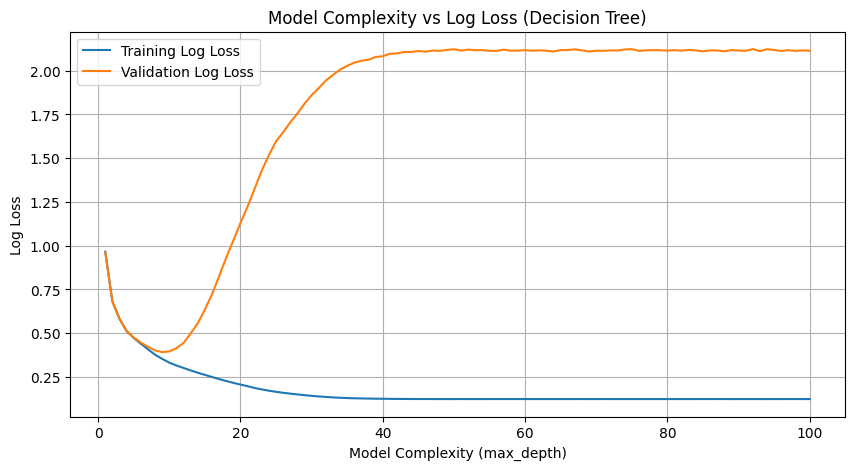

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------------------------------
# Convert y to Series so that indexing works cleanly
# ----------------------------------------------------
y_train = pd.Series(y_train)
y_test  = pd.Series(y_test)

# ----------------------------------------------------
# Reset indices of X and y together
# ----------------------------------------------------
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# ----------------------------------------------------
# Subsample 250,000 rows for efficient complexity curve
# ----------------------------------------------------
sample_size = min(250_000, len(X_train), len(X_test))

X_train_sub = X_train.sample(sample_size, random_state=42)
y_train_sub = y_train.loc[X_train_sub.index]

X_test_sub = X_test.sample(sample_size, random_state=42)
y_test_sub = y_test.loc[X_test_sub.index]

# ----------------------------------------------------
# Complexity curve (log-loss + accuracy)
# ----------------------------------------------------
depths = range(1, 101, 1)
train_losses_curve = []
test_losses_curve = []
train_acc_curve = []
test_acc_curve = []

best_params = halving_search.best_params_

for d in depths:
    model = DecisionTreeClassifier(
        criterion=best_params['criterion'],
        min_samples_leaf=best_params['min_samples_leaf'],
        min_samples_split=best_params['min_samples_split'],
        max_depth=d
    )

    model.fit(X_train_sub, y_train_sub)

    # Predict probabilities for log-loss
    train_proba = model.predict_proba(X_train_sub)
    test_proba  = model.predict_proba(X_test_sub)

    train_losses_curve.append(log_loss(y_train_sub, train_proba))
    test_losses_curve.append(log_loss(y_test_sub, test_proba))

    # Accuracy
    y_train_pred = model.predict(X_train_sub)
    y_test_pred  = model.predict(X_test_sub)
    train_acc_curve.append(accuracy_score(y_train_sub, y_train_pred))
    test_acc_curve.append(accuracy_score(y_test_sub, y_test_pred))


# ----------------------------------------------------
# Plot Log Loss Curve
# ----------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(depths, train_losses_curve, label="Training Log Loss")
plt.plot(depths, test_losses_curve, label="Validation Log Loss")
plt.xlabel("Model Complexity (max_depth)")
plt.ylabel("Log Loss")
plt.title("Model Complexity vs Log Loss (Decision Tree)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import log_loss

train_loss = log_loss(y_train, dt_model_4.predict_proba(X_train))
test_loss  = log_loss(y_test,  dt_model_4.predict_proba(X_test))
print("------------------------")
print("Training Loss")
print(train_loss)
print("------------------------")
print("Testing Error:")
print(test_loss)
print("------------------------")
print(":)")
acc_gap  = train_accuracy - test_accuracy
loss_gap = test_loss - train_loss
print("------------------------")
print("Accuracy Gap:")
print(acc_gap)
print("------------------------")
print("Loss Gap:")
print(loss_gap)
print("------------------------")


------------------------
Training Loss
0.3343433551990626
------------------------
Testing Error:
0.3655590139101725
------------------------
:)
------------------------
Accuracy Gap:
0.0010790113889563857
------------------------
Loss Gap:
0.031215658711109873
------------------------


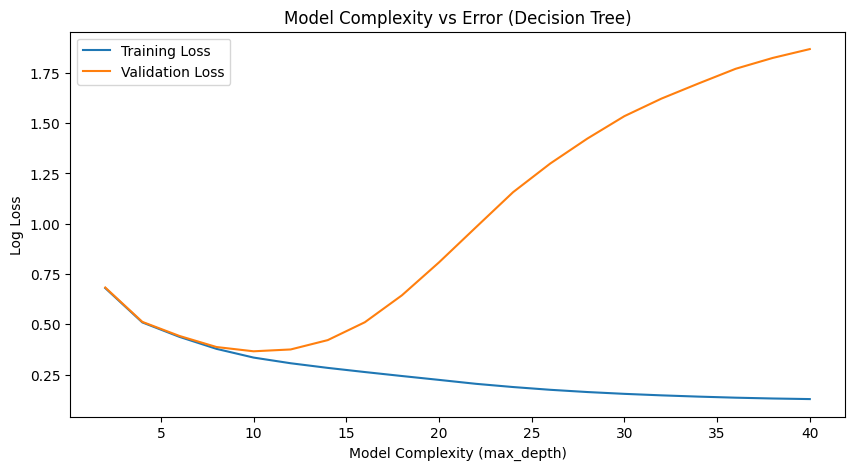

In [ ]:
depths = range(2, 41, 2)
train_losses_curve = []
test_losses_curve = []
train_acc_curve = []
test_acc_curve = []

# Use best hyperparameters, vary only depth
best_params = halving_search.best_params_

for d in depths:
    loss_model = DecisionTreeClassifier(
        criterion=best_params['criterion'],
        min_samples_leaf=best_params['min_samples_leaf'],
        min_samples_split=best_params['min_samples_split'],
        max_depth=d
    )

    loss_model.fit(X_train, y_train)

    # Loss
    train_proba = loss_model.predict_proba(X_train)
    test_proba  = loss_model.predict_proba(X_test)
    train_losses_curve.append(log_loss(y_train, train_proba)) 
    test_losses_curve.append(log_loss(y_test, test_proba))

    # Accuracy
    y_train_pred = loss_model.predict(X_train)
    y_test_pred  = loss_model.predict(X_test)
    train_acc_curve.append(accuracy_score(y_train, y_train_pred))
    test_acc_curve.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10,5))
plt.plot(depths, train_losses_curve, label="Training Loss")
plt.plot(depths, test_losses_curve, label="Validation Loss")
plt.xlabel("Model Complexity (max_depth)")
plt.ylabel("Log Loss")
plt.title("Model Complexity vs Error (Decision Tree)")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# ============================================================
# Use the SAME BEST PARAMETERS from HalvingGridSearch
# ============================================================
best_params = halving_search.best_params_
print("Using Best Params for CV:", best_params)

# ============================================================
# Stratified Shuffle-Split (same dataset you prepared earlier)
# ============================================================

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

accuracies = []
fold = 1

for train_idx, test_idx in sss.split(X, y):
    print(f"\n=== Fold {fold} ===")

    X_train_cv = X.iloc[train_idx]
    X_test_cv  = X.iloc[test_idx]
    y_train_cv = y[train_idx]
    y_test_cv  = y[test_idx]

    # Build model with best hyperparameters
    dt_cv = DecisionTreeClassifier(**best_params)

    # Train
    dt_cv.fit(X_train_cv, y_train_cv)

    # Predict & evaluate
    y_pred_cv = dt_cv.predict(X_test_cv)
    acc = accuracy_score(y_test_cv, y_pred_cv)

    print(f"Accuracy: {acc:.4f}")
    accuracies.append(acc)
    fold += 1

# ============================================================
# Summary
# ============================================================
print("\n---------------------------------------------------------")
print("Stratified Shuffle-Split Mean Accuracy:", np.mean(accuracies))
print("Std Deviation:", np.std(accuracies))
print("---------------------------------------------------------")


Using Best Params for CV: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

=== Fold 1 ===
Accuracy: 0.8885

=== Fold 2 ===
Accuracy: 0.8903

=== Fold 3 ===
Accuracy: 0.8897

=== Fold 4 ===
Accuracy: 0.8906

=== Fold 5 ===
Accuracy: 0.8899

---------------------------------------------------------
Stratified Shuffle-Split Mean Accuracy: 0.8897962838891136
Std Deviation: 0.0007302756779370842
---------------------------------------------------------
